In [1]:
%env CUDA_VISIBLE_DEVICES=6
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

env: CUDA_VISIBLE_DEVICES=6


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'Conv_VAE_log_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
batch_size = 50
train_loader, valid_loader, test_loader = mnist(batch_size = batch_size, valid=10000, transform=mnist_tanh)

fixed_data, _ = next(iter(test_loader))
fixed_data = fixed_data.cuda()

In [6]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [7]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [8]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [9]:
class Net(nn.Module):
    def __init__(self, latent_size=32, gamma=1e-3, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        self.gamma = gamma
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, pool_layer=None)
            
        self.fce = FullyConnected([32*2*2, latent_size*2])
        self.fcd = FullyConnected([latent_size, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.fce(flatten)
        self.mu, self.logvar = h.split(self.latent_size, dim=1)
        return self.mu, self.logvar
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        if self.training:
            std = logvar.mul(0.5).exp()
            h = self._sample(mu.shape[0]) * std + mu
        else:
            h = mu
        x = self.decode(h)
        return x, h
    
    def _sample(self, n):
        return torch.randn([n, self.latent_size]).cuda()
    
    def loss(self, output, target, size_average=True):
        self._loss = F.mse_loss(output, target, size_average=size_average)
        return self._loss

In [10]:
latent_size = 2

model = Net(latent_size, 0.005, batchnorm=False, dropout=False, optim_type='Adam', lr=1e-4).cuda()

D = FullyConnected([latent_size, 64, 1], dropout=0.0, activation_fn=nn.ReLU(), flatten=True, last_fn=nn.Sigmoid()).cuda()
D_optimizer = optim.Adam(D.parameters(), lr=1e-4)

train_log = []
test_log = []

batch_zeros = torch.zeros((batch_size, 1)).cuda()
batch_ones = torch.ones((batch_size, 1)).cuda()

fixed_z = torch.randn((batch_size, latent_size)).cuda()


In [11]:
def train(epoch, model, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        
        # train D
        D.zero_grad()
        model.optim.zero_grad()

        output, h = model(data)

        z = torch.randn((data.shape[0], latent_size)).cuda()
        
        fake_pred = D(h)
        true_pred = D(z)

        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)

        D_loss = 0.5*(fake_loss + true_loss)

        D_loss.backward()
        D_optimizer.step()

        #Train model

        model.optim.zero_grad()
        D.zero_grad()

        output, h = model(data)

        fake_pred = D(h)
        
        M_loss = model.loss(output, data) + F.binary_cross_entropy_with_logits(fake_pred, batch_ones)

        M_loss.backward()
        model.optim.step()

            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' M = {:.4f}, D = {:.4f}'.format(M_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' M = {:.4f}, D = {:.4f}'.format(M_loss.item(), D_loss.item())
        if log is not None:
            log.append((M_loss, D_loss))
        print(line + losses)

In [12]:
def test(model, loader, epoch, log=None):
    test_size = len(loader)
    test_reconstruction_loss = 0.0
    test_D_loss = 0.0
    with torch.no_grad():
        for data, _ in loader:
            data = data.cuda()
            output, h = model(data)
            
            z = torch.randn((batch_size, latent_size)).cuda()
            
            fake_pred = D(h)
            true_pred = D(z)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss = 0.5*(fake_loss + true_loss)
            
            M_loss = model.loss(output, data).item() + F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
            
            test_reconstruction_loss += M_loss
            test_D_loss += D_loss
    

    test_reconstruction_loss /= test_size
    test_D_loss /= test_size
    report = 'Test losses: {:.4f}/{:.4f}'.format(test_reconstruction_loss, test_D_loss)

    if log is not None:
        log.append((test_reconstruction_loss, test_D_loss))
    with torch.no_grad():
        ae_data, _ = model(fixed_data)
        ae_data = ae_data.data.cpu().numpy()
        fixed_gen = model.decode(fixed_z).data.cpu().numpy()
        plot_mnist(ae_data, (5, 10))
        plot_mnist(fixed_gen, (5, 10))
    print(report)

/cephfs/home/seliverstov/oml/env/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [0/50000 (0%)]	Losses  M = 1.3873, D = 0.7176
Train Epoch: 1 [10000/50000 (20%)]	Losses  M = 1.0536, D = 0.6779
Train Epoch: 1 [20000/50000 (40%)]	Losses  M = 0.9777, D = 0.7098
Train Epoch: 1 [30000/50000 (60%)]	Losses  M = 0.8735, D = 0.7112
Train Epoch: 1 [40000/50000 (80%)]	Losses  M = 0.8731, D = 0.7224
Train Epoch: 1 [50000/50000 (100%)]	Losses  M = 0.9084, D = 0.6974


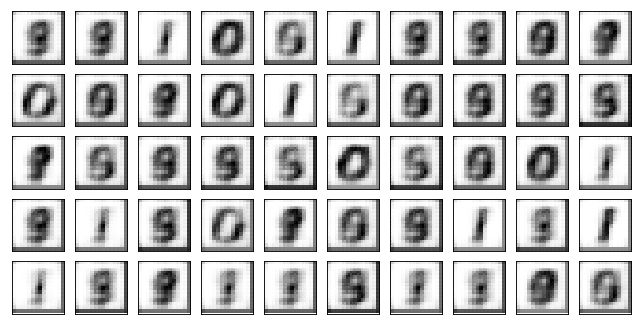

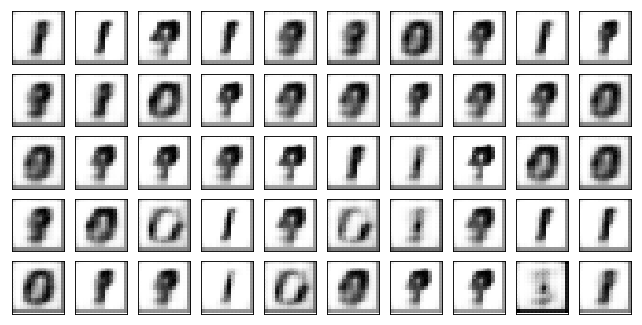

Test losses: 0.8956/0.6984
Train Epoch: 2 [0/50000 (0%)]	Losses  M = 0.8905, D = 0.6989
Train Epoch: 2 [10000/50000 (20%)]	Losses  M = 0.8674, D = 0.7027
Train Epoch: 2 [20000/50000 (40%)]	Losses  M = 0.8684, D = 0.7007
Train Epoch: 2 [30000/50000 (60%)]	Losses  M = 0.8625, D = 0.6990
Train Epoch: 2 [40000/50000 (80%)]	Losses  M = 0.8608, D = 0.6980
Train Epoch: 2 [50000/50000 (100%)]	Losses  M = 0.8546, D = 0.6967


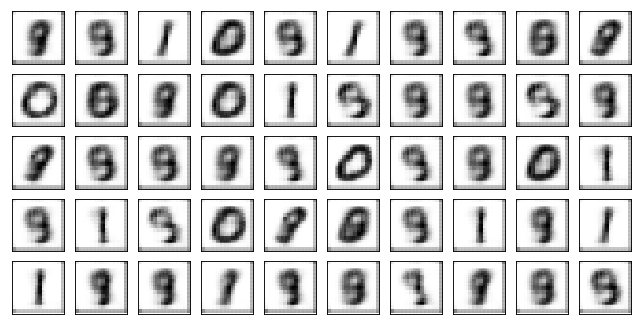

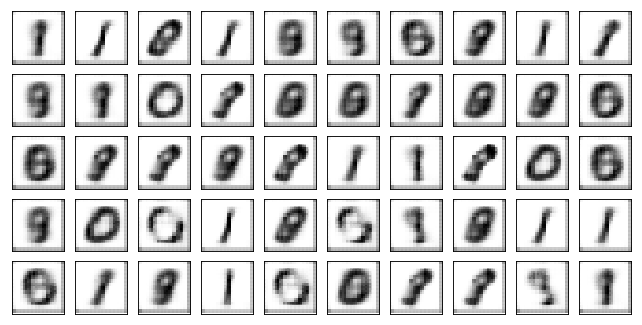

Test losses: 0.8491/0.6968
Train Epoch: 3 [0/50000 (0%)]	Losses  M = 0.8357, D = 0.6961
Train Epoch: 3 [10000/50000 (20%)]	Losses  M = 0.8383, D = 0.6970
Train Epoch: 3 [20000/50000 (40%)]	Losses  M = 0.8333, D = 0.6952
Train Epoch: 3 [30000/50000 (60%)]	Losses  M = 0.8678, D = 0.6940
Train Epoch: 3 [40000/50000 (80%)]	Losses  M = 0.8544, D = 0.6946
Train Epoch: 3 [50000/50000 (100%)]	Losses  M = 0.8589, D = 0.6941


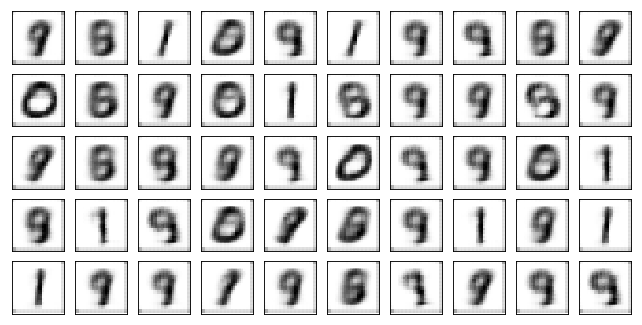

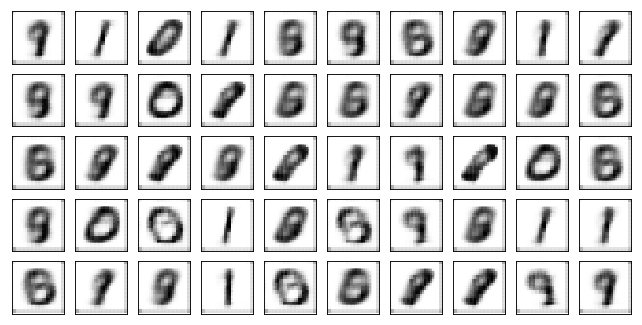

Test losses: 0.8579/0.6947
Train Epoch: 4 [0/50000 (0%)]	Losses  M = 0.8703, D = 0.6948
Train Epoch: 4 [10000/50000 (20%)]	Losses  M = 0.8390, D = 0.6938
Train Epoch: 4 [20000/50000 (40%)]	Losses  M = 0.8610, D = 0.6945
Train Epoch: 4 [30000/50000 (60%)]	Losses  M = 0.8522, D = 0.6937
Train Epoch: 4 [40000/50000 (80%)]	Losses  M = 0.8577, D = 0.6938
Train Epoch: 4 [50000/50000 (100%)]	Losses  M = 0.8596, D = 0.6932


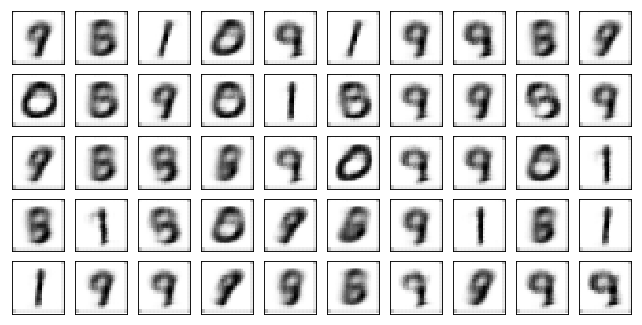

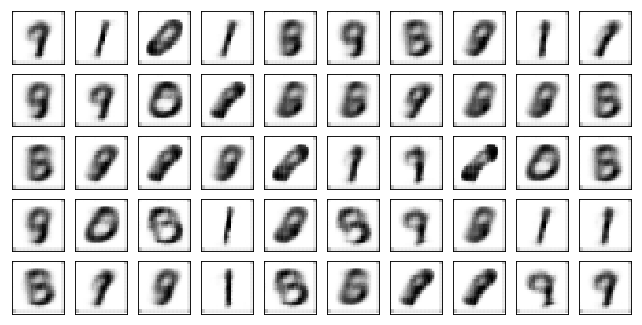

Test losses: 0.8638/0.6937
Train Epoch: 5 [0/50000 (0%)]	Losses  M = 0.8664, D = 0.6937
Train Epoch: 5 [10000/50000 (20%)]	Losses  M = 0.8615, D = 0.6937
Train Epoch: 5 [20000/50000 (40%)]	Losses  M = 0.8716, D = 0.6934
Train Epoch: 5 [30000/50000 (60%)]	Losses  M = 0.8698, D = 0.6935
Train Epoch: 5 [40000/50000 (80%)]	Losses  M = 0.8944, D = 0.6935
Train Epoch: 5 [50000/50000 (100%)]	Losses  M = 0.8499, D = 0.6936


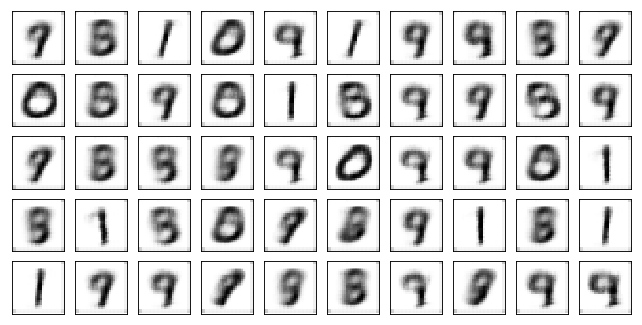

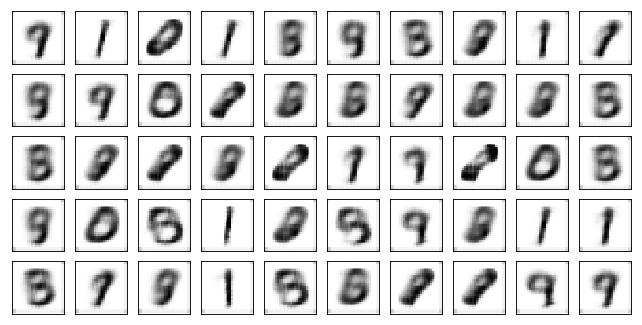

Test losses: 0.8681/0.6934
Train Epoch: 6 [0/50000 (0%)]	Losses  M = 0.8665, D = 0.6933
Train Epoch: 6 [10000/50000 (20%)]	Losses  M = 0.8780, D = 0.6933
Train Epoch: 6 [20000/50000 (40%)]	Losses  M = 0.8509, D = 0.6932
Train Epoch: 6 [30000/50000 (60%)]	Losses  M = 0.8759, D = 0.6929
Train Epoch: 6 [40000/50000 (80%)]	Losses  M = 0.8679, D = 0.6929
Train Epoch: 6 [50000/50000 (100%)]	Losses  M = 0.8629, D = 0.6935


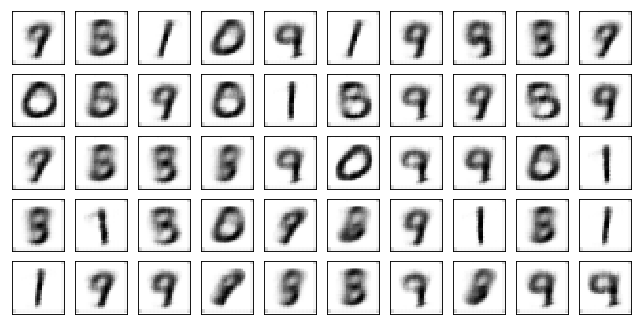

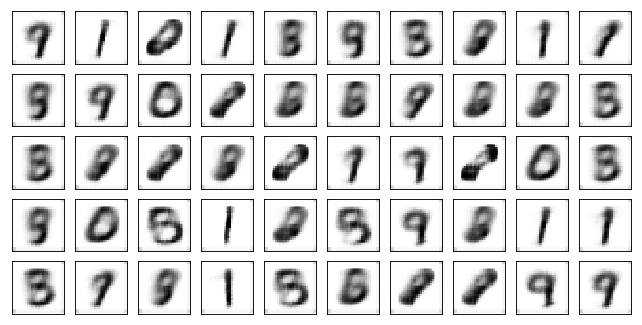

Test losses: 0.8696/0.6932
Train Epoch: 7 [0/50000 (0%)]	Losses  M = 0.8577, D = 0.6933
Train Epoch: 7 [10000/50000 (20%)]	Losses  M = 0.8787, D = 0.6934
Train Epoch: 7 [20000/50000 (40%)]	Losses  M = 0.8814, D = 0.6933
Train Epoch: 7 [30000/50000 (60%)]	Losses  M = 0.8843, D = 0.6931
Train Epoch: 7 [40000/50000 (80%)]	Losses  M = 0.8712, D = 0.6930
Train Epoch: 7 [50000/50000 (100%)]	Losses  M = 0.8572, D = 0.6930


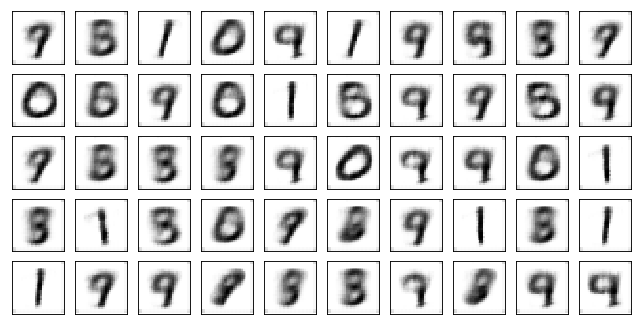

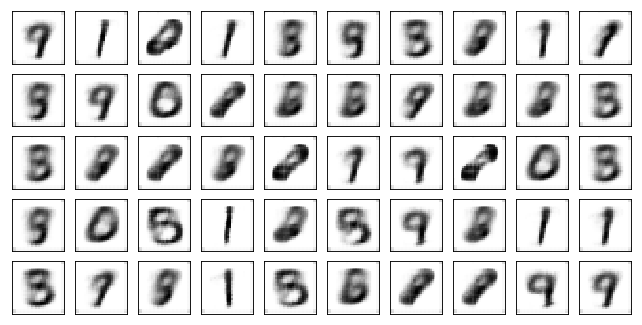

Test losses: 0.8704/0.6931
Train Epoch: 8 [0/50000 (0%)]	Losses  M = 0.8728, D = 0.6931
Train Epoch: 8 [10000/50000 (20%)]	Losses  M = 0.8703, D = 0.6930
Train Epoch: 8 [20000/50000 (40%)]	Losses  M = 0.8688, D = 0.6931
Train Epoch: 8 [30000/50000 (60%)]	Losses  M = 0.8795, D = 0.6933
Train Epoch: 8 [40000/50000 (80%)]	Losses  M = 0.8794, D = 0.6930
Train Epoch: 8 [50000/50000 (100%)]	Losses  M = 0.8645, D = 0.6931


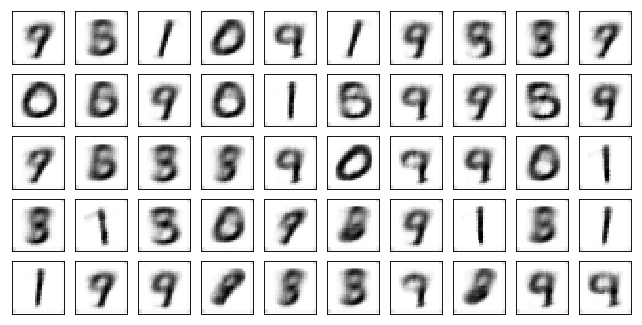

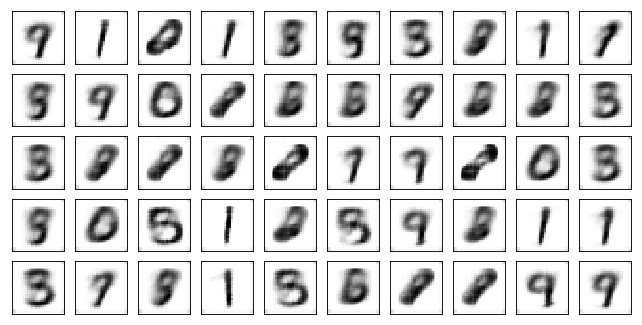

Test losses: 0.8698/0.6931
Train Epoch: 9 [0/50000 (0%)]	Losses  M = 0.8487, D = 0.6931
Train Epoch: 9 [10000/50000 (20%)]	Losses  M = 0.8518, D = 0.6930
Train Epoch: 9 [20000/50000 (40%)]	Losses  M = 0.8648, D = 0.6927
Train Epoch: 9 [30000/50000 (60%)]	Losses  M = 0.8581, D = 0.6931
Train Epoch: 9 [40000/50000 (80%)]	Losses  M = 0.8684, D = 0.6929
Train Epoch: 9 [50000/50000 (100%)]	Losses  M = 0.8718, D = 0.6930


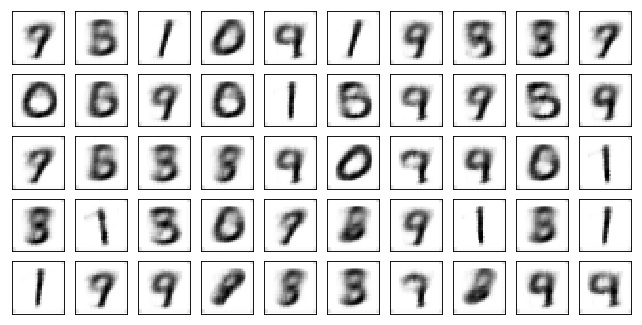

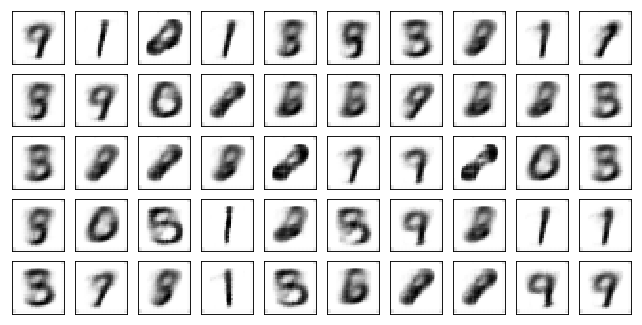

Test losses: 0.8681/0.6930
Train Epoch: 10 [0/50000 (0%)]	Losses  M = 0.8646, D = 0.6927
Train Epoch: 10 [10000/50000 (20%)]	Losses  M = 0.8403, D = 0.6929
Train Epoch: 10 [20000/50000 (40%)]	Losses  M = 0.8701, D = 0.6933
Train Epoch: 10 [30000/50000 (60%)]	Losses  M = 0.8742, D = 0.6925
Train Epoch: 10 [40000/50000 (80%)]	Losses  M = 0.8490, D = 0.6931
Train Epoch: 10 [50000/50000 (100%)]	Losses  M = 0.8687, D = 0.6930


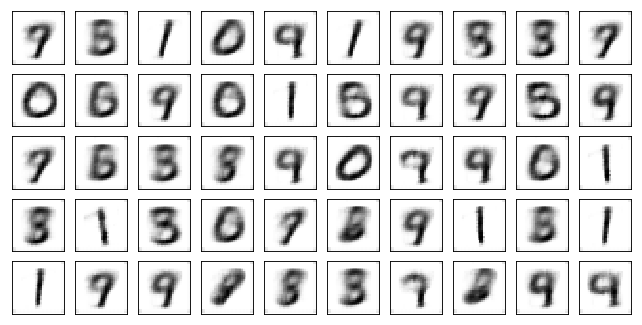

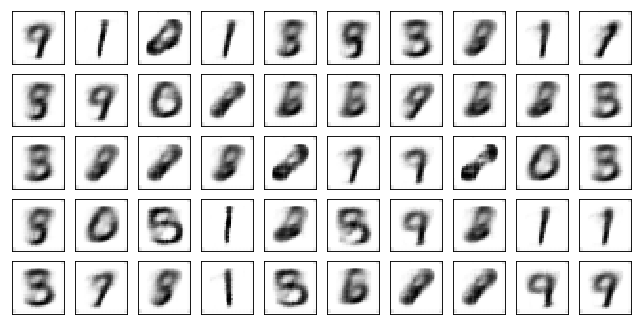

Test losses: 0.8664/0.6930
Train Epoch: 11 [0/50000 (0%)]	Losses  M = 0.8740, D = 0.6930
Train Epoch: 11 [10000/50000 (20%)]	Losses  M = 0.8455, D = 0.6928
Train Epoch: 11 [20000/50000 (40%)]	Losses  M = 0.8649, D = 0.6923
Train Epoch: 11 [30000/50000 (60%)]	Losses  M = 0.8626, D = 0.6926
Train Epoch: 11 [40000/50000 (80%)]	Losses  M = 0.8546, D = 0.6930
Train Epoch: 11 [50000/50000 (100%)]	Losses  M = 0.8624, D = 0.6931


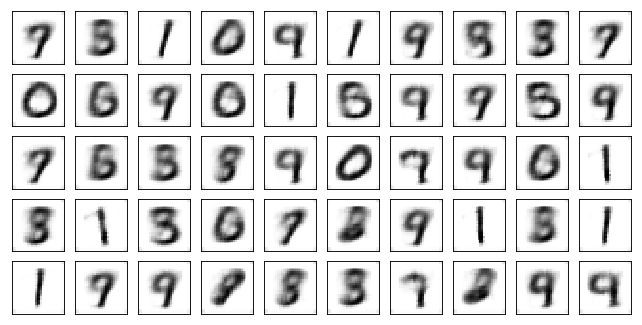

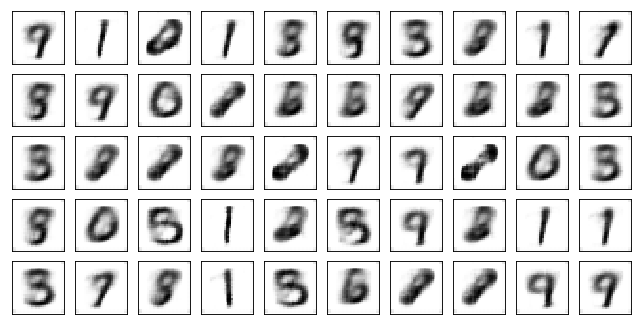

Test losses: 0.8646/0.6930
Train Epoch: 12 [0/50000 (0%)]	Losses  M = 0.8764, D = 0.6930
Train Epoch: 12 [10000/50000 (20%)]	Losses  M = 0.8669, D = 0.6931
Train Epoch: 12 [20000/50000 (40%)]	Losses  M = 0.8591, D = 0.6929
Train Epoch: 12 [30000/50000 (60%)]	Losses  M = 0.8550, D = 0.6928
Train Epoch: 12 [40000/50000 (80%)]	Losses  M = 0.8613, D = 0.6932
Train Epoch: 12 [50000/50000 (100%)]	Losses  M = 0.8653, D = 0.6930


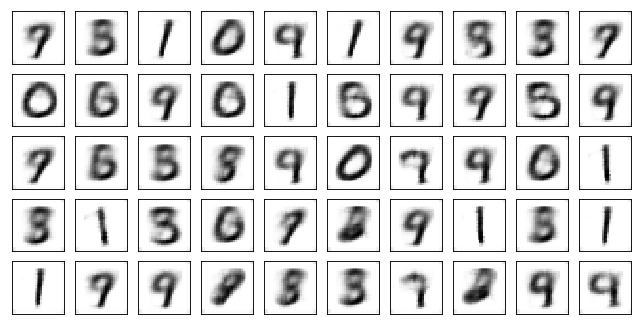

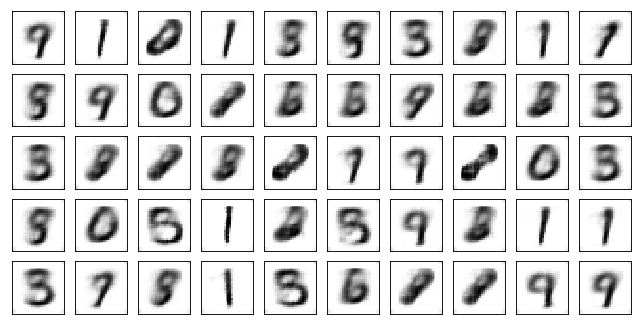

Test losses: 0.8636/0.6930
Train Epoch: 13 [0/50000 (0%)]	Losses  M = 0.8761, D = 0.6934
Train Epoch: 13 [10000/50000 (20%)]	Losses  M = 0.8628, D = 0.6927
Train Epoch: 13 [20000/50000 (40%)]	Losses  M = 0.8716, D = 0.6935
Train Epoch: 13 [30000/50000 (60%)]	Losses  M = 0.8548, D = 0.6932
Train Epoch: 13 [40000/50000 (80%)]	Losses  M = 0.8576, D = 0.6932
Train Epoch: 13 [50000/50000 (100%)]	Losses  M = 0.8701, D = 0.6931


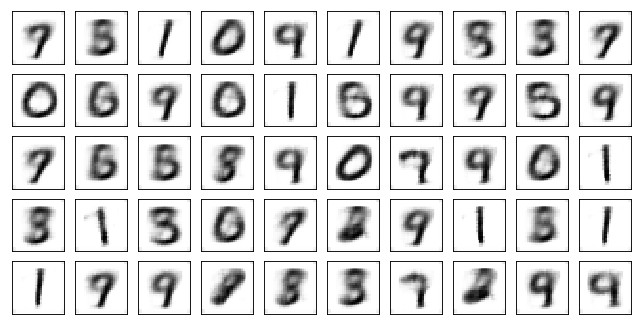

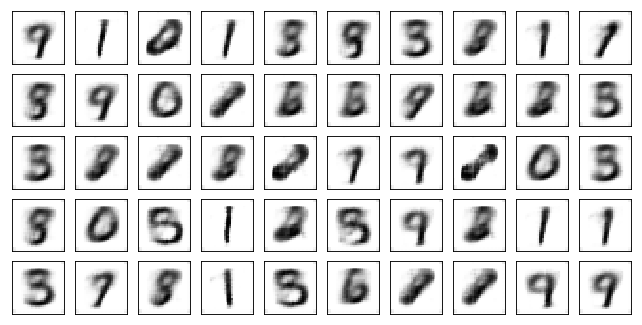

Test losses: 0.8623/0.6930
Train Epoch: 14 [0/50000 (0%)]	Losses  M = 0.8514, D = 0.6932
Train Epoch: 14 [10000/50000 (20%)]	Losses  M = 0.8671, D = 0.6928
Train Epoch: 14 [20000/50000 (40%)]	Losses  M = 0.8584, D = 0.6930
Train Epoch: 14 [30000/50000 (60%)]	Losses  M = 0.8447, D = 0.6930
Train Epoch: 14 [40000/50000 (80%)]	Losses  M = 0.8493, D = 0.6929
Train Epoch: 14 [50000/50000 (100%)]	Losses  M = 0.8559, D = 0.6928


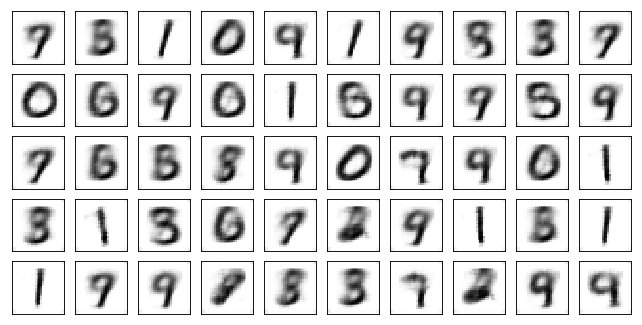

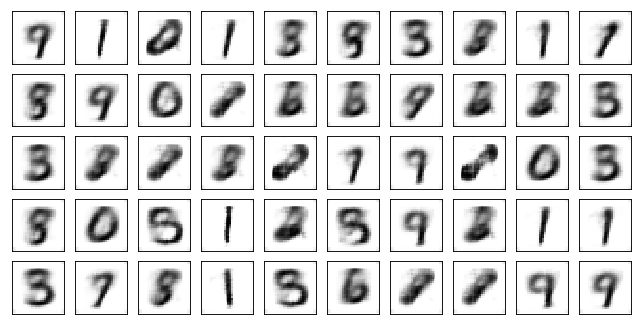

Test losses: 0.8616/0.6930
Train Epoch: 15 [0/50000 (0%)]	Losses  M = 0.8674, D = 0.6930
Train Epoch: 15 [10000/50000 (20%)]	Losses  M = 0.8573, D = 0.6937
Train Epoch: 15 [20000/50000 (40%)]	Losses  M = 0.8541, D = 0.6932
Train Epoch: 15 [30000/50000 (60%)]	Losses  M = 0.8636, D = 0.6931
Train Epoch: 15 [40000/50000 (80%)]	Losses  M = 0.8597, D = 0.6934
Train Epoch: 15 [50000/50000 (100%)]	Losses  M = 0.8709, D = 0.6928


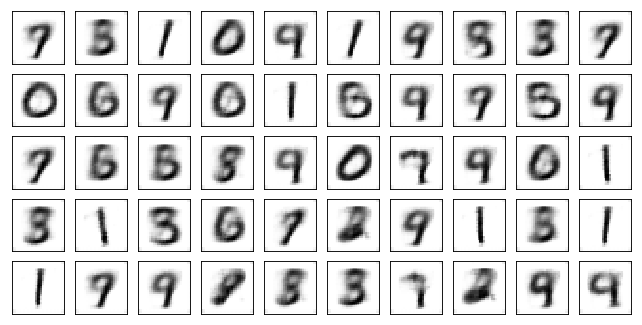

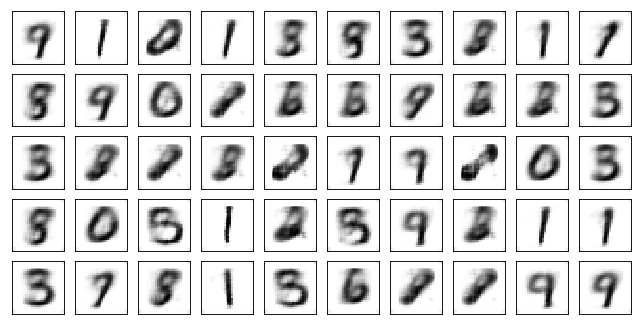

Test losses: 0.8605/0.6930
Train Epoch: 16 [0/50000 (0%)]	Losses  M = 0.8391, D = 0.6928
Train Epoch: 16 [10000/50000 (20%)]	Losses  M = 0.8450, D = 0.6930
Train Epoch: 16 [20000/50000 (40%)]	Losses  M = 0.8425, D = 0.6929
Train Epoch: 16 [30000/50000 (60%)]	Losses  M = 0.8580, D = 0.6931
Train Epoch: 16 [40000/50000 (80%)]	Losses  M = 0.8710, D = 0.6931
Train Epoch: 16 [50000/50000 (100%)]	Losses  M = 0.8538, D = 0.6931


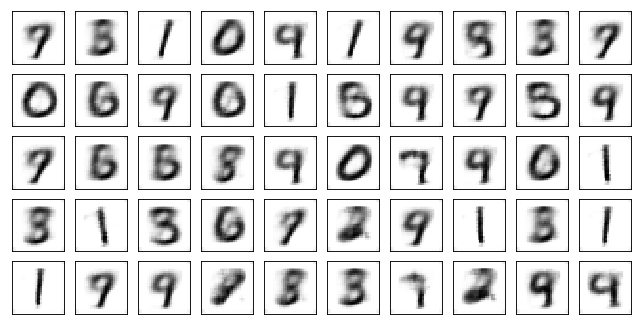

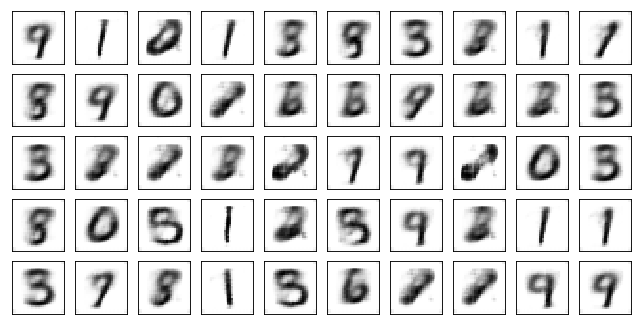

Test losses: 0.8603/0.6930
Train Epoch: 17 [0/50000 (0%)]	Losses  M = 0.8584, D = 0.6926
Train Epoch: 17 [10000/50000 (20%)]	Losses  M = 0.8650, D = 0.6935
Train Epoch: 17 [20000/50000 (40%)]	Losses  M = 0.8676, D = 0.6930
Train Epoch: 17 [30000/50000 (60%)]	Losses  M = 0.8475, D = 0.6932
Train Epoch: 17 [40000/50000 (80%)]	Losses  M = 0.8643, D = 0.6929
Train Epoch: 17 [50000/50000 (100%)]	Losses  M = 0.8656, D = 0.6928


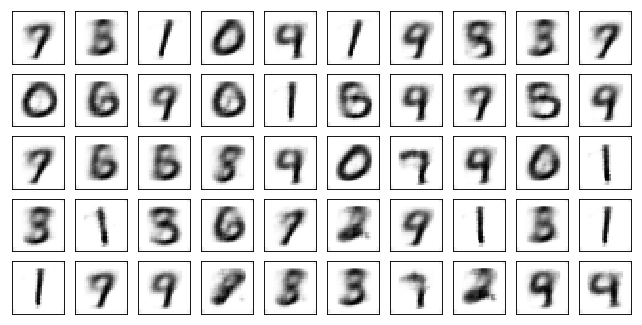

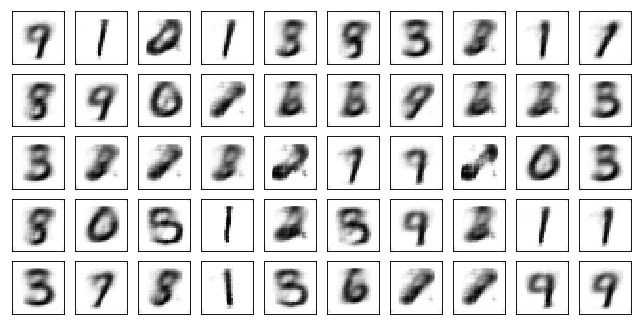

Test losses: 0.8596/0.6930
Train Epoch: 18 [0/50000 (0%)]	Losses  M = 0.8630, D = 0.6930
Train Epoch: 18 [10000/50000 (20%)]	Losses  M = 0.8572, D = 0.6934
Train Epoch: 18 [20000/50000 (40%)]	Losses  M = 0.8678, D = 0.6930
Train Epoch: 18 [30000/50000 (60%)]	Losses  M = 0.8519, D = 0.6932
Train Epoch: 18 [40000/50000 (80%)]	Losses  M = 0.8540, D = 0.6930
Train Epoch: 18 [50000/50000 (100%)]	Losses  M = 0.8459, D = 0.6934


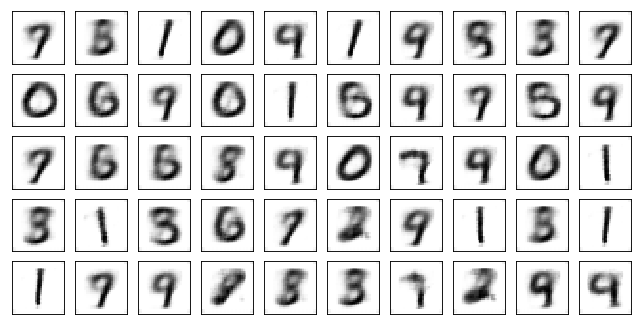

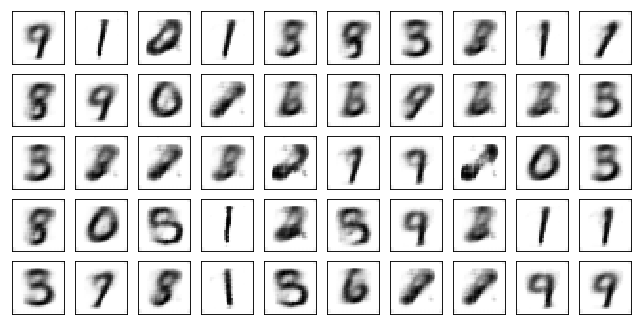

Test losses: 0.8591/0.6930
Train Epoch: 19 [0/50000 (0%)]	Losses  M = 0.8784, D = 0.6932
Train Epoch: 19 [10000/50000 (20%)]	Losses  M = 0.8625, D = 0.6932
Train Epoch: 19 [20000/50000 (40%)]	Losses  M = 0.8484, D = 0.6928
Train Epoch: 19 [30000/50000 (60%)]	Losses  M = 0.8619, D = 0.6931
Train Epoch: 19 [40000/50000 (80%)]	Losses  M = 0.8771, D = 0.6930
Train Epoch: 19 [50000/50000 (100%)]	Losses  M = 0.8632, D = 0.6931


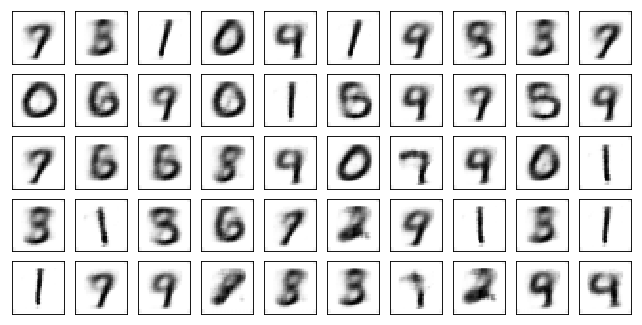

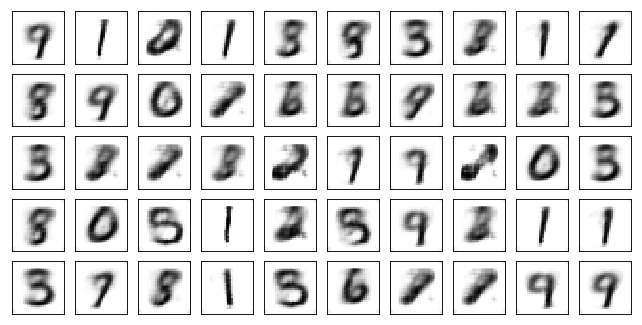

Test losses: 0.8587/0.6930
Train Epoch: 20 [0/50000 (0%)]	Losses  M = 0.8554, D = 0.6932
Train Epoch: 20 [10000/50000 (20%)]	Losses  M = 0.8383, D = 0.6934
Train Epoch: 20 [20000/50000 (40%)]	Losses  M = 0.8697, D = 0.6930
Train Epoch: 20 [30000/50000 (60%)]	Losses  M = 0.8594, D = 0.6932
Train Epoch: 20 [40000/50000 (80%)]	Losses  M = 0.8469, D = 0.6935
Train Epoch: 20 [50000/50000 (100%)]	Losses  M = 0.8539, D = 0.6929


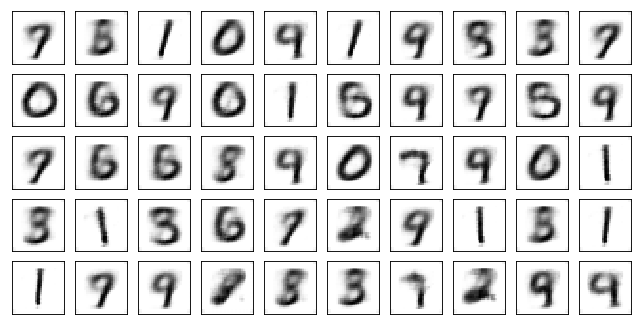

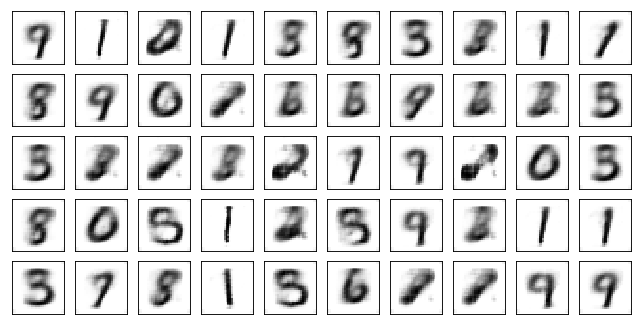

Test losses: 0.8576/0.6931
Train Epoch: 21 [0/50000 (0%)]	Losses  M = 0.8608, D = 0.6932
Train Epoch: 21 [10000/50000 (20%)]	Losses  M = 0.8578, D = 0.6928
Train Epoch: 21 [20000/50000 (40%)]	Losses  M = 0.8555, D = 0.6929
Train Epoch: 21 [30000/50000 (60%)]	Losses  M = 0.8480, D = 0.6929
Train Epoch: 21 [40000/50000 (80%)]	Losses  M = 0.8608, D = 0.6926
Train Epoch: 21 [50000/50000 (100%)]	Losses  M = 0.8420, D = 0.6930


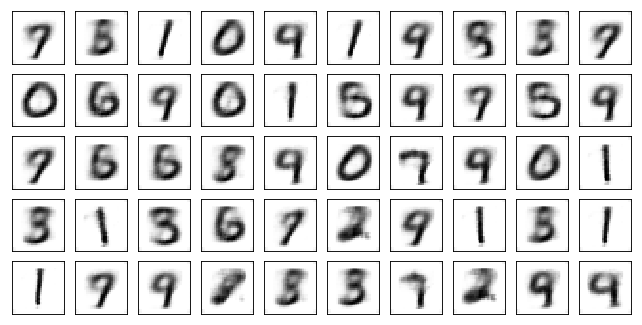

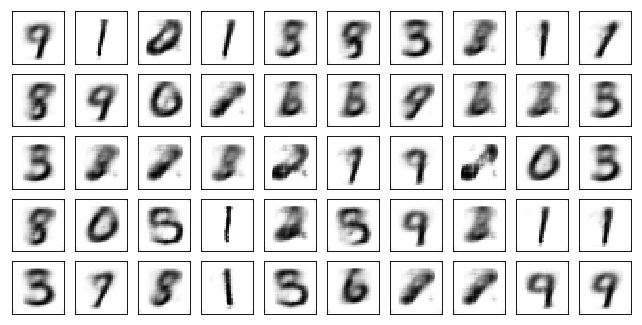

Test losses: 0.8578/0.6931
Train Epoch: 22 [0/50000 (0%)]	Losses  M = 0.8551, D = 0.6933
Train Epoch: 22 [10000/50000 (20%)]	Losses  M = 0.8617, D = 0.6933
Train Epoch: 22 [20000/50000 (40%)]	Losses  M = 0.8482, D = 0.6925
Train Epoch: 22 [30000/50000 (60%)]	Losses  M = 0.8599, D = 0.6929
Train Epoch: 22 [40000/50000 (80%)]	Losses  M = 0.8551, D = 0.6932
Train Epoch: 22 [50000/50000 (100%)]	Losses  M = 0.8651, D = 0.6923


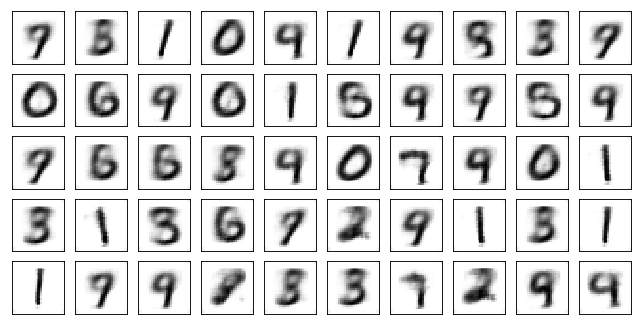

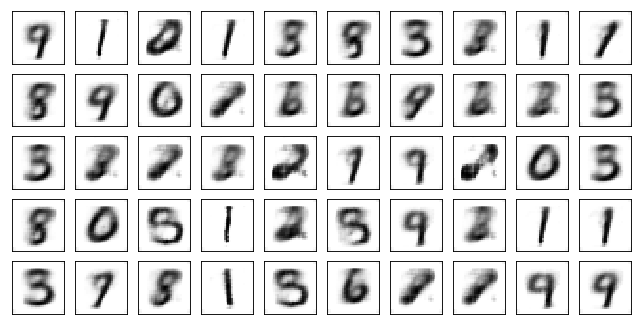

Test losses: 0.8579/0.6931
Train Epoch: 23 [0/50000 (0%)]	Losses  M = 0.8715, D = 0.6938
Train Epoch: 23 [10000/50000 (20%)]	Losses  M = 0.8703, D = 0.6929
Train Epoch: 23 [20000/50000 (40%)]	Losses  M = 0.8590, D = 0.6933
Train Epoch: 23 [30000/50000 (60%)]	Losses  M = 0.8553, D = 0.6936
Train Epoch: 23 [40000/50000 (80%)]	Losses  M = 0.8672, D = 0.6931
Train Epoch: 23 [50000/50000 (100%)]	Losses  M = 0.8652, D = 0.6927


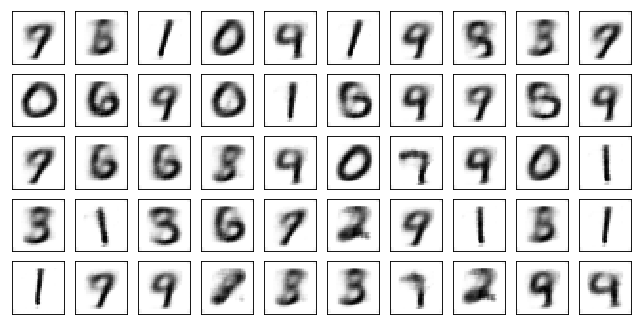

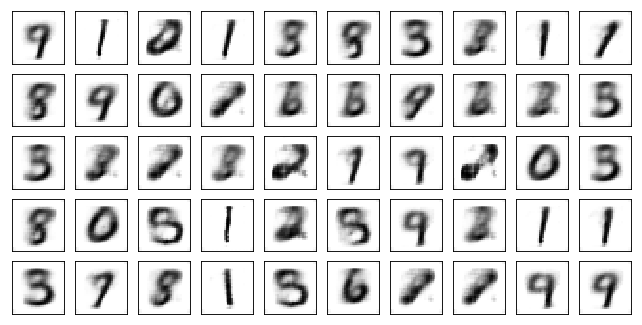

Test losses: 0.8577/0.6931
Train Epoch: 24 [0/50000 (0%)]	Losses  M = 0.8484, D = 0.6935
Train Epoch: 24 [10000/50000 (20%)]	Losses  M = 0.8618, D = 0.6929
Train Epoch: 24 [20000/50000 (40%)]	Losses  M = 0.8536, D = 0.6937
Train Epoch: 24 [30000/50000 (60%)]	Losses  M = 0.8699, D = 0.6931
Train Epoch: 24 [40000/50000 (80%)]	Losses  M = 0.8471, D = 0.6929
Train Epoch: 24 [50000/50000 (100%)]	Losses  M = 0.8475, D = 0.6932


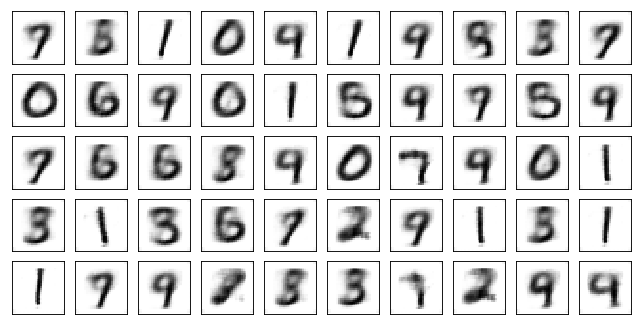

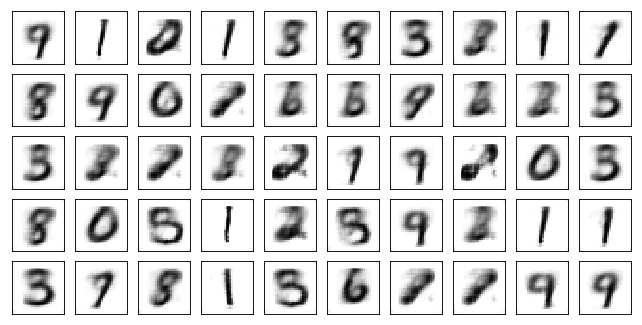

Test losses: 0.8566/0.6931
Train Epoch: 25 [0/50000 (0%)]	Losses  M = 0.8615, D = 0.6934
Train Epoch: 25 [10000/50000 (20%)]	Losses  M = 0.8389, D = 0.6940
Train Epoch: 25 [20000/50000 (40%)]	Losses  M = 0.8646, D = 0.6929
Train Epoch: 25 [30000/50000 (60%)]	Losses  M = 0.8437, D = 0.6931
Train Epoch: 25 [40000/50000 (80%)]	Losses  M = 0.8504, D = 0.6929
Train Epoch: 25 [50000/50000 (100%)]	Losses  M = 0.8289, D = 0.6933


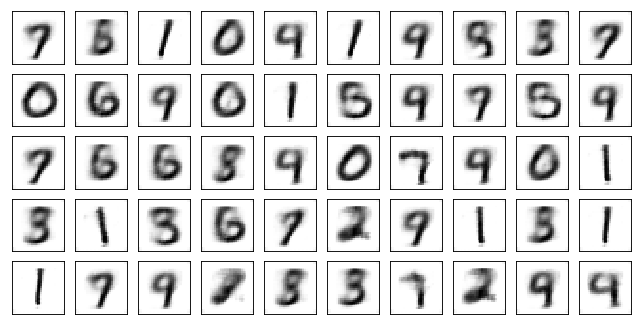

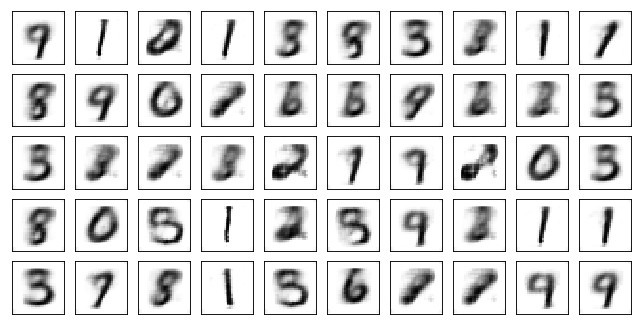

Test losses: 0.8564/0.6931
Train Epoch: 26 [0/50000 (0%)]	Losses  M = 0.8665, D = 0.6931
Train Epoch: 26 [10000/50000 (20%)]	Losses  M = 0.8520, D = 0.6932
Train Epoch: 26 [20000/50000 (40%)]	Losses  M = 0.8567, D = 0.6936
Train Epoch: 26 [30000/50000 (60%)]	Losses  M = 0.8547, D = 0.6935
Train Epoch: 26 [40000/50000 (80%)]	Losses  M = 0.8560, D = 0.6933
Train Epoch: 26 [50000/50000 (100%)]	Losses  M = 0.8432, D = 0.6927


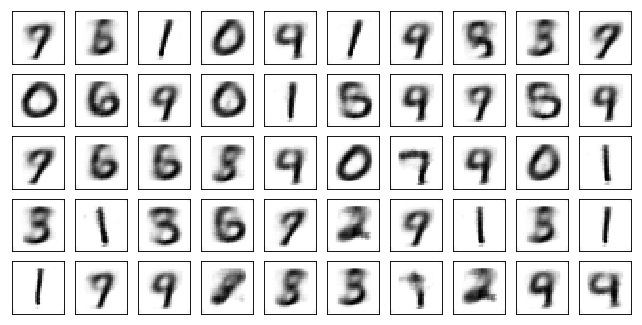

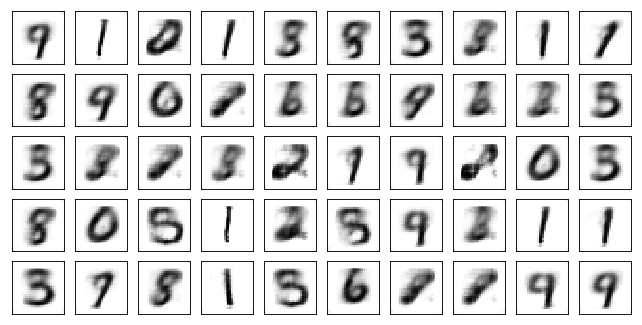

Test losses: 0.8564/0.6930
Train Epoch: 27 [0/50000 (0%)]	Losses  M = 0.8559, D = 0.6927
Train Epoch: 27 [10000/50000 (20%)]	Losses  M = 0.8681, D = 0.6929
Train Epoch: 27 [20000/50000 (40%)]	Losses  M = 0.8560, D = 0.6933
Train Epoch: 27 [30000/50000 (60%)]	Losses  M = 0.8521, D = 0.6936
Train Epoch: 27 [40000/50000 (80%)]	Losses  M = 0.8497, D = 0.6928
Train Epoch: 27 [50000/50000 (100%)]	Losses  M = 0.8558, D = 0.6928


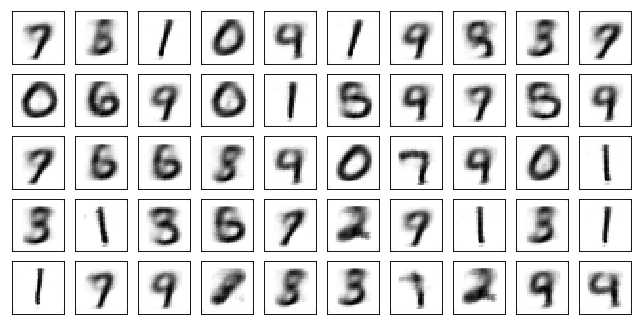

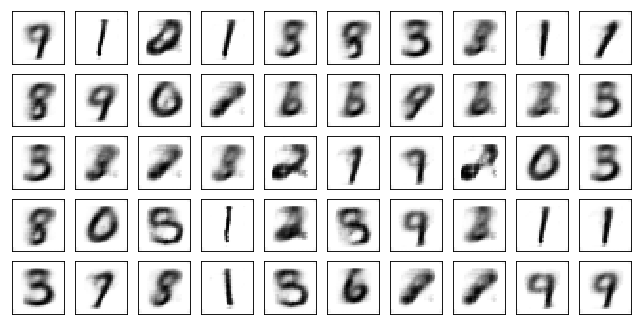

Test losses: 0.8557/0.6930
Train Epoch: 28 [0/50000 (0%)]	Losses  M = 0.8379, D = 0.6930
Train Epoch: 28 [10000/50000 (20%)]	Losses  M = 0.8670, D = 0.6929
Train Epoch: 28 [20000/50000 (40%)]	Losses  M = 0.8582, D = 0.6930
Train Epoch: 28 [30000/50000 (60%)]	Losses  M = 0.8573, D = 0.6936
Train Epoch: 28 [40000/50000 (80%)]	Losses  M = 0.8632, D = 0.6933
Train Epoch: 28 [50000/50000 (100%)]	Losses  M = 0.8496, D = 0.6936


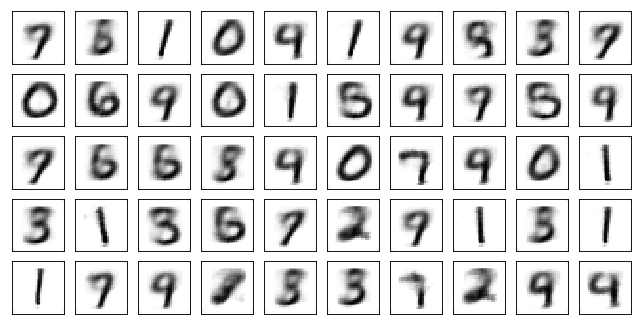

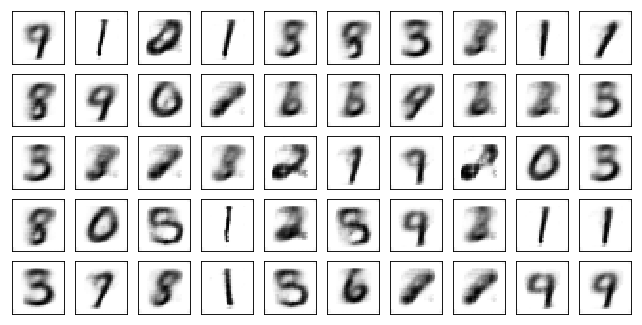

Test losses: 0.8557/0.6931
Train Epoch: 29 [0/50000 (0%)]	Losses  M = 0.8545, D = 0.6933
Train Epoch: 29 [10000/50000 (20%)]	Losses  M = 0.8551, D = 0.6930
Train Epoch: 29 [20000/50000 (40%)]	Losses  M = 0.8607, D = 0.6932
Train Epoch: 29 [30000/50000 (60%)]	Losses  M = 0.8430, D = 0.6931
Train Epoch: 29 [40000/50000 (80%)]	Losses  M = 0.8475, D = 0.6931
Train Epoch: 29 [50000/50000 (100%)]	Losses  M = 0.8624, D = 0.6930


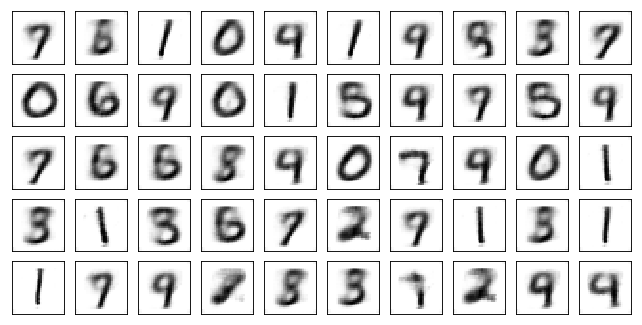

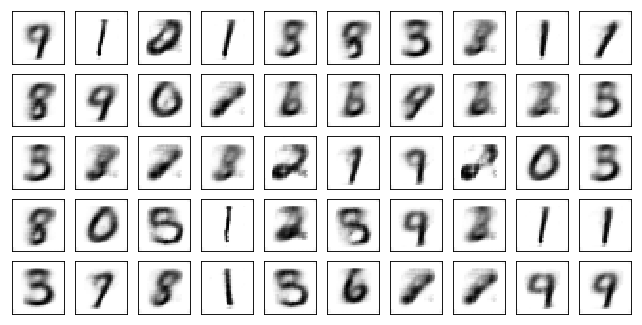

Test losses: 0.8559/0.6930
Train Epoch: 30 [0/50000 (0%)]	Losses  M = 0.8537, D = 0.6929
Train Epoch: 30 [10000/50000 (20%)]	Losses  M = 0.8463, D = 0.6934
Train Epoch: 30 [20000/50000 (40%)]	Losses  M = 0.8467, D = 0.6928
Train Epoch: 30 [30000/50000 (60%)]	Losses  M = 0.8373, D = 0.6933
Train Epoch: 30 [40000/50000 (80%)]	Losses  M = 0.8460, D = 0.6931
Train Epoch: 30 [50000/50000 (100%)]	Losses  M = 0.8586, D = 0.6934


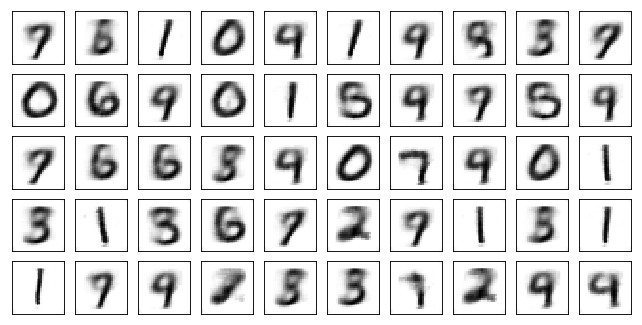

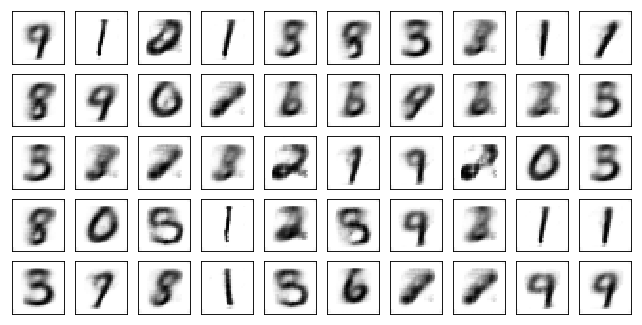

Test losses: 0.8551/0.6931


In [13]:
for epoch in range(1, 31):
    model.train()
    train(epoch, model, train_log)
    
    model.eval()
    test(model, valid_loader, epoch, test_log)

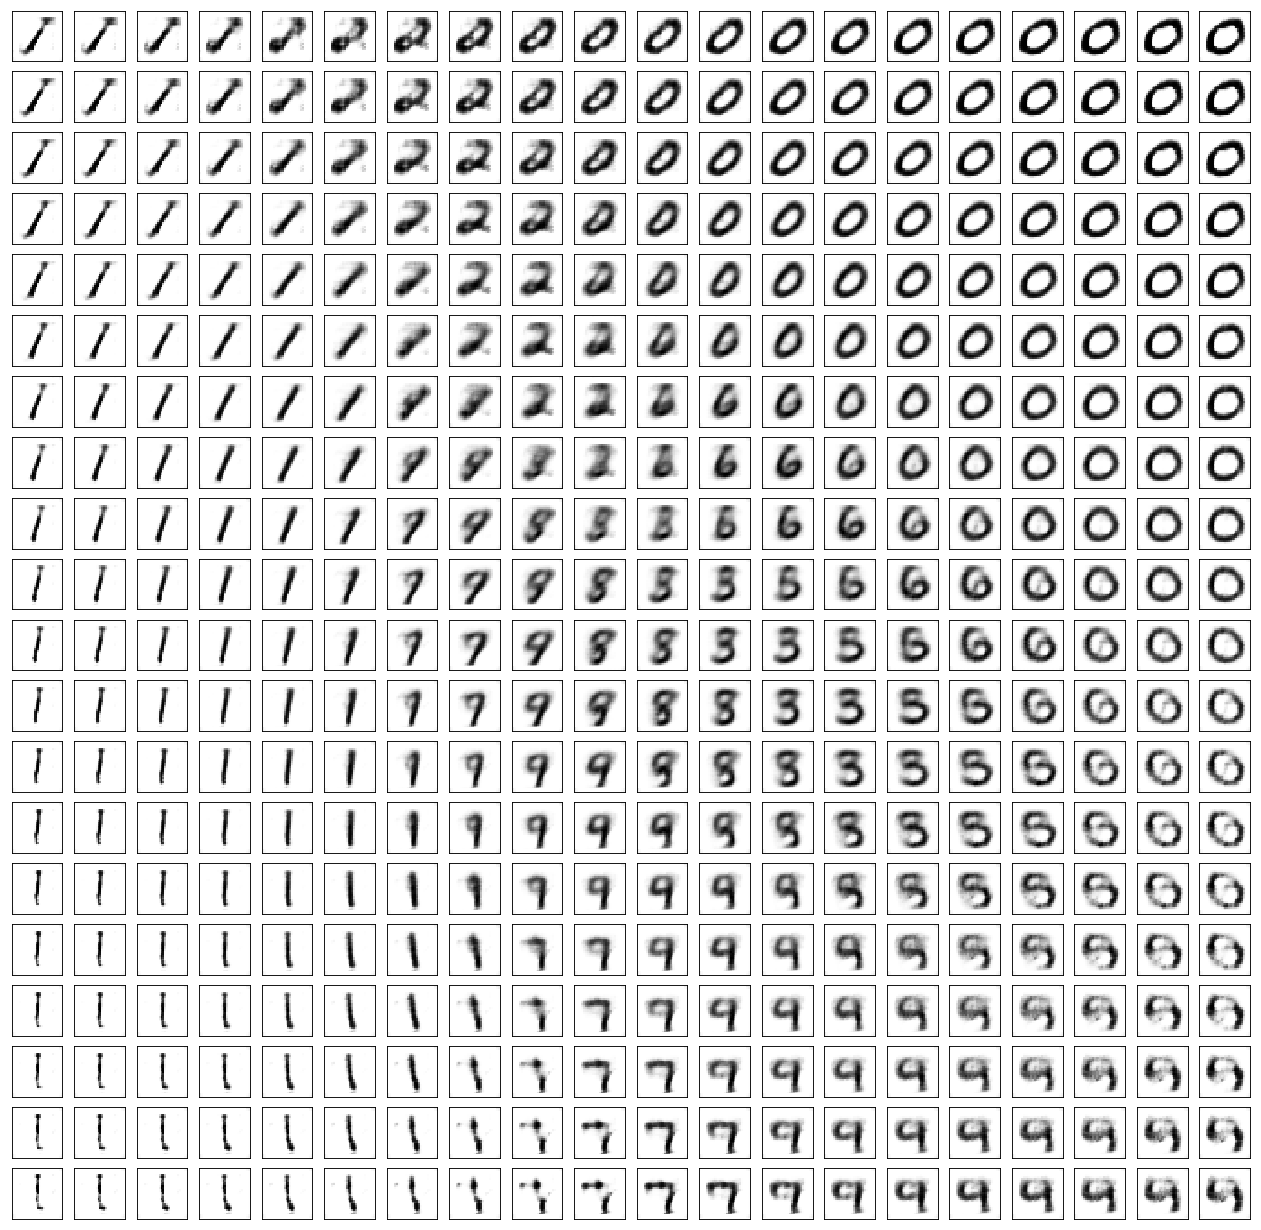

In [14]:
model.eval()
n_points = 20
import itertools
data2 = torch.zeros(n_points*n_points,2).cuda()
for t, (i, j) in enumerate(itertools.product(np.linspace(-3,3,n_points),np.linspace(-3,3,n_points))):
    data2[t,:]=torch.tensor((i,j))
dec2 = model.decode(data2)
plot_mnist(dec2.detach().cpu().numpy(), (n_points, n_points))